# TPAM scheme simulator

This notebook works to simulate the TPAM brightness boosting scheme, with the aim to assess the effects of other imperfections in the source, and potentiall run a search for other scehemes.

Where possible it uses the perveval package, and where that is not possible I have endeavoured to make it 'perceval friendly'. This mainly is in the use of mixed states.

(I also make use of my own horrible plotting function, apologies).

The general structure is:

1) Some utility functions which can mainly be ignored
2) Defining evolution and measurement functions for perceval mixed states (please don't naively trust!)
3) Checking that in the case of no TPA we get the expected behaviour
4) Defining a funtion that can evolve a mixed state through a non-linear map on single mode number states (i.e TPA)
5) Running a simulation of the scheme and benchmarking the code against the expected probabilities
6) Checking the effect of imperfect TPA on the heralding probability
7) Checking the effect of non-zero g2 on the boosted brightness

The next steps are to extend the results to look at the behaviour in the following cases:
1) The effect of imperfect number resolving detectors
2) The effect of linear loss on the scheme
3) The effect partial distinguishability

Ideally I would like to try use it to find new schemes.

In [135]:
import numpy as np
import matplotlib.pyplot as plt 
import perceval as pcvl
import warnings


############################################################################################################
#EVERYTHING ELSE IN THIS CELL IS JUST MY HORRIBLE PLOTTING FUNCTION, FEEL FREE TO GET RID OF THIS AND REPLACE
############################################################################################################


%matplotlib inline
#%config InlineBackend.figure_formats = ['png']
cm_fig = 1/2.00000054
s = 5
font_size=14
dotsize=30
fontweight="normal"
colors = ['#BA01FF', '#9300CA', '#71009B', '#FF8F00', '#C06C00', '#FABA1E']
plt.rcParams.update({
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 1000,  # to adjust notebook inline plot size
    'axes.labelsize': font_size, # fontsize for x and y labels (was 10)
    'axes.titlesize': font_size,
    'font.size': font_size, # was 10
    'legend.fontsize': font_size, # was 10
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    "font.weight": fontweight,
    "axes.labelweight" : fontweight,
    #'text.usetex': True,
    'figure.figsize': [15.25*cm_fig*2, 6*cm_fig*2],
    'font.family': 'serif',
    'font.sans-serif' : ['New Century Schoolbook']
    #'text.latex.preamble' : r'\usepackage{gensymb}\usepackage{cmbright}\usepackage{amsmath}\usepackage{upgreek}\usepackage{textgreek}\usepackage{siunitx}\sisetup{detect-weight=true, detect-family=true}'
})

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

def generic_line_plotter(x_values, 
                        y_values, 
                        x_label,
                        y_label,
                        data_labels,
                        title,
                        dotsize=dotsize,
                        linewidth=4,
                        plottype=None,
                        color_indexes=None,
                        save=False,
                        savepath=None,
                        evl=None,
                        evu=None):
    
    """All in one plotting function - this is terrible practice, I urge you to turn back.
    Allows for the plotting of multiple datasets on one graph.

    Parameters:
            x_values (arr) - A list of lists. Allows for plotting multiple datasets.
            y_values (arr) - A list of lists. Allows for plotting multiple datasets.
            x_label (str) - The x axis label
            y_label (str) - The x axis label
            data_labels (arr) - An array of strings which are the legend labels
            title (str) - Plot title
            Plottype (str) - Choose from: 'line' 'scatter' , 'line scatter' and 'errors' if you want to include errors
            color_indexes (arr) - array of ints which pick a color
            save (Bool) - Do you want to save the plot
            savepath (str) - where to save it 
            evl (arr) - The array of errors corresponding to the lower bound
            evu (arr) - The array of errors corresponding to the upper bound
 
    """
    

    #initialise axes 
    fig, ax1 = plt.subplots(num=None,dpi=60, facecolor='w', edgecolor='k')    
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    
   
    #Loop through every set of y and x values to plot
    for i in range(np.shape(y_values)[0]):
        
        #if colors are specified, use them
        if color_indexes is not None:
            c=colors[color_indexes[i]]
        else:
            c=colors[2*i]
        
        if plottype is None or plottype[i] is None: 
            ax1.plot(x_values[i] ,y_values[i], lw=linewidth, color=c)
            ax1.scatter(x_values[i] ,y_values[i], label=data_labels[i], s=dotsize, color=c)

        elif plottype[i]=='line':
            ax1.plot(x_values[i] ,y_values[i], label=data_labels[i], lw=linewidth, color=c)
        
        elif plottype[i]=='scatter':
            ax1.scatter(x_values[i] ,y_values[i], label=data_labels[i], s=dotsize, color=c)
        
        elif plottype[i] == 'line_scatter':
            if data_labels[i] is None:
                ax1.plot(x_values[i] ,y_values[i], lw=linewidth, color=c)
                ax1.scatter(x_values[i] ,y_values[i], s=dotsize, color=c)
            else:
                ax1.plot(x_values[i] ,y_values[i], lw=linewidth, color=c)
                ax1.scatter(x_values[i] ,y_values[i], label=data_labels[i], s=dotsize, color=c)

        elif plottype[i]=='errors':
                ax1.plot(x_values[i] ,y_values[i], lw=linewidth, color=c)
                if evl and evu:
                    ax1.errorbar(x_values[i], y_values[i], yerr=(evl[i]-y_values[i], y_values[i]-evu[i]), fmt='-o',label=data_labels[i], elinewidth=2,color=c)
                    ax1.fill_between(x_values[i], evl[i], evu[i], color=c,label=data_labels[i], alpha=0.3)
                elif evl and not evu:
                    ax1.errorbar(x_values[i], y_values[i], yerr=(evl[i]-y_values[i], y_values[i]), fmt='-o',label=data_labels[i], elinewidth=2,color=c)
                    ax1.fill_between(x_values[i], evl[i], y_values[i], color=c,label=data_labels[i], alpha=0.3)
                elif evu and not evl:
                    ax1.errorbar(x_values[i], y_values[i], yerr=(y_values[i], y_values[i]), fmt='-o',label=data_labels[i], elinewidth=2,color=c)
                    ax1.fill_between(x_values[i], y_values[i], evu[i], color=c,label=data_labels[i], alpha=0.3)

    ax1.tick_params(axis='y')
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc='upper left',frameon=False)
    ax1.set_title(title)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save:
        plt.savefig(savepath+'.pdf', dpi=400)
    else:
        plt.show() 

## Utility functions

There is a good chance that some if not all of these are already in perceval and I am just missing them. Ideally these should be replaced with calls to functions or class methods within perceval.

In [136]:
def count_total_photons_in_basis_state(state):

    """Function which counts the total photons across all modes of a state.
    I.e |0,1,2> input state will return 3
        Parameters:
            input_state (obj) - The perceval basis state object that you want to count total photons
        Returns:
            total photons (int) - Number of photons in the basis state."""

    state1=str(state)
    ss1=state1.replace('|', '')
    ss2=ss1.replace('>', '')
    ss3=ss2.split(',')

    total_photons=np.sum(np.asfarray(ss3))

    return int(total_photons)


def access_mode_occupation_of_basis_state(state, mode_index):

    """Function which returns the occupation of a given mode in a given basis state vector
    I.e input state =|0,1,2>, mode index = 2,  will return 2
        Parameters:
            input_state (obj) - The perceval basis state object that you want look at
            mode_index (int) - the mode within the basis state you want to know the occupation no of 
        Returns:
            occup (int) - Number of photons in given mode of the basis state. """

    state1=str(state)
    ss1=state1.replace('|', '')
    ss2=ss1.replace('>', '')
    ss3=ss2.split(',')

    occup=ss3[mode_index]

    return int(occup)


def is_number_conserved(state_1, state_2):

    '''Function which takes two state strings with fock state occupations, 
    and checks if they have the same photon number. Useful to skip non-photon 
    number conserving transfers.
        Parameters:
            state_1 (obj) - The perceval basis state object that you want look at
            state_2 (obj) - The perceval basis state object that you want look at
        Returns:
            number_conserved (bool) - Whether the two states have the same number of photons.
    '''

    n1=count_total_photons_in_basis_state(state_1)
    n2=count_total_photons_in_basis_state(state_2)

    if int(n1)==int(n2):
        number_conserved=True
    else:
        number_conserved=False

    return number_conserved



def count_max_occupation_number_in_svd(state):

    """Function which takes a mixed state and returns the maximal
    number of photons within that mixed state.
        Parameters:""
            state (obj) - The perceval svd object representing the mixed state.
        Returns:
            max (int) - returns the maximum possible number of photons in the mixture"""

    max=0
    for key, value in state.items():
        
        if np.around(value,4) == 0.0: #If the term has no probability ignore
            pass

        else:
            phot=count_total_photons_in_basis_state(key)
            if phot > max:
                max=phot
            else:
                pass
    return max

def count_max_occupation_number_in_state_vector(state):

    """Function which takes a state vector and returns the maximal
    number of photons within that mixed state.
        Parameters:""
            state (obj) - The perceval svd object representing the mixed state.
        Returns:
            max (int) - returns the maximum possible number of photons in the mixture"""

    max=0
    for key, value in state.items():
        
        if np.around(value,4) == 0.0: #If the term has no probability ignore
            pass

        else:
            phot=count_total_photons_in_basis_state(key)
            if phot > max:
                max=phot
            else:
                pass
    return max



def probability_check(mixed_state):
    """Function which simply checks whether the probability amplitudes 
    in a mixed state sum to 1.
            Parameters:
                state (obj) - The perceval svd object representing the mixed state.
            Returns:
                (bool) - True if probabilities sum to 1, False otherwise"""
    prob_sum=0.0
    for key, value in mixed_state.items():
        prob_sum+=np.abs(value)

    if np.around(np.abs(prob_sum),4)==1.0:
        return True
    else:
        print('Probability is not conserved, Psum={}'.format(np.abs(prob_sum)))
        return False 

def make_basis_state_a_string(basis_state):

    state1=str(basis_state)
    ss1=state1.replace('|', '')
    ss2=ss1.replace('>', '')
    ss3=ss2.split(',')

    return ss3



def generate_empty_mixed_state(no_modes,
                            max_mode_occupation):
    """Quick and dirty method to generate an empty perceval mixed state
    for a given number of modes and max occup number. 

    TODO: This is a nasty quick fix as it takes up memory for empty states.
          Find a way to evolve and measure states without using this function.
          
            Parameters:
                no_modes (int)  = number of modes in the state
                max_mode_occupation (int) - the maximum permitted number of photons per mode
            Returns:
                output_state (obj) - Perceval svd object with all the probabilites set to 0."""

    
    state_dict={}
    for i in range(max_mode_occupation+1):
        state_string="|{}>".format(i)
        sv=pcvl.BasicState(state_string)
        state_dict[sv]=0

    single_mode_state=pcvl.SVDistribution(state_dict)
    output_state=single_mode_state

    for j in range(no_modes-1):
        output_state=   output_state.__mul__(single_mode_state)

    
    return output_state



def prepare_input_state(n,
                    source_brightnesses=[0.8,0.8,0.0],
                    source_purities=[1,1,1]):

    """Function which generates an n mode perceval mixed state,
     with a probabilistic source in each mode.

        Parameters:
                n (int) - number of sources 
                source_brightnesses (arr) - array of floats between 0 and 1 which are the source brightnesses 
                source_purities (arr) - array of floats between 0 and 1 which are the source purities 
        Returns:
                output_state (obj) - The perceval svd representing the mixed state output
    """

    if len(source_purities)!=n or len(source_brightnesses)!=n:
        raise Exception('Number of sources doesnt match the number of brightnesses or purities.')
    
    for s in range(n):
        source= pcvl.Source(brightness=source_brightnesses[s], purity=source_purities[s])
        source_dist=source.probability_distribution()
        if s==0:
            output_state=source_dist
        else:
            output_state=output_state.__mul__(source_dist)

    return output_state


### Defining evolution, measurement and non-linear evolution functions for mixed states.
Perceval as far as I can tell can't natively handle the evolution of mixed states through a LO circuit. The SVD object also has no measure method, so I define a quick and dirty one here that allows you to postselect on the measurement or not.

Here we define:

evolve_mixed_state() - Evolves a mixed state through a unitary

measure_mixed_state() - measures a mixed state and allows you to postselect

evolve_state_vector_through_nonlinearity() - Evolves a pcvl state vector through a non-linear map on number basis states

evolve_mixed_state_through_nonlinearity() - Does the same but for a mixed state 



WARNING: These functions are probably naive and likely inefficient.

In [137]:

def evolve_mixed_state(Unitary, input_mixed_state):

    """ Perceval cannot natively propogate a mixed state through
    a unitary and return the output state (I think).

        Parameters:
                Unitary (obj) - the perceval circuit representing the unitary matrix you 
                                wish to propogate your state through
                input_state (obj) - The perceval svd representing the mixed state input

        Returns:
                output_state (obj) - The perceval svd representing the mixed state output
    """

    backend = pcvl.BackendFactory.get_backend("Naive")
    simulator = backend(Unitary)
    output_state_dictionary={}


    #This loop goes through every StateVector in the mixed state  
    for state_vector, inp_state_prob in input_mixed_state.items():

        if inp_state_prob == 0.0 or 0: #dont calculate transitions if no probability of this state 
            out_state_vector=state_vector
        else:
            out_state_vector=simulator.evolve(state_vector)

        output_state_dictionary[out_state_vector]=inp_state_prob

    output_state=pcvl.SVDistribution(output_state_dictionary)
    probability_check(output_state)

    return output_state

    

def measure_mixed_state(input_state, 
                        meas_mode,
                        postselect_on_click=False,
                        postselect_on_state=None,
                        print_outcome=False):

    """ Perceval cannot natively measure a mixed state (I think). I have tried to implement 
    a general measurement function, that allows for postselection. This function requires 
    a lot more benchmarking so be careful when using. This was the trickiest function to write
    and can probably be simplified.

            Parameters:
                    input_state (obj) - The perceval svd representing the mixed state to be measured
                    meas_mode (int)  - The mode index you wish to measure
                    postselect_on_click (Bool) - Performs a measurement where we postselect on the occurence of ANY click (|1>, |2>,...)
                    postselect_on_state (str) - Performs a postselected measurement where we post select on a specific state 
                                                i.e postselected_on_state = '|1>'
                    print_outcome (bool) - Bool to print measurement outcome or not 

            Returns:
                    measured_state (obj) - The state of the measured mode 
                    output_state (obj)   - The mixed state object representing the non-measured part of the state 
                    click_probability (float) - The probability of getting a click in the specified measurement        
        """
        
    post_measurement_state_dict={}
    measured_state_dict={} 
    click_probability=0

    if postselect_on_click and postselect_on_state:
        raise Exception('Invalid postselection. Cannot postselect on any click, and a given state.')


    for input_state_vector, input_state_probability in input_state.items(): # Loop through every state vector in the mixed state 

        meas=input_state_vector.measure(modes=meas_mode)    #measure out the appropriate mode of each state vector 

        for s, (p, sv) in meas.items():    


            #First of all lets deal with the state of the photon being measured
            if s in measured_state_dict.keys():
                measured_state_dict[s]+=p*input_state_probability   #Bookmark the probabilities of each measurement outcome, scaled by the mixed state probabilities.
            else:
                measured_state_dict[s]=p*input_state_probability   
            

            #Now deal with the remaining state for each case (postselected on click, postselected on state, not postselected )
            if postselect_on_click and str(s)=='|0>':               #If we are postselecting on getting a click, ignore this outcome 
                pass
            elif postselect_on_state is not None and str(s) != postselect_on_state:       #If we are postselecting on a specific outcome, ignore all other outcomes.
                pass
            else:   
                sv.normalize()
                click_probability=click_probability+p*input_state_probability
                if sv in post_measurement_state_dict.keys():
                    post_measurement_state_dict[sv]=post_measurement_state_dict[sv]+input_state_probability*p    #Dictionary to be used to create the new SVD post measurement
                else:
                    post_measurement_state_dict[sv]=input_state_probability*p
               

                
    if click_probability==0 and postselect_on_click or postselect_on_state:
        warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')

    output_state=pcvl.SVDistribution(post_measurement_state_dict)       #create the SVD representing the post measurement mixed state 
    measured_state = pcvl.SVDistribution(measured_state_dict)           #Create SVD representing the measured mode - makes renormalisation super easy

    output_state.normalize()
    measured_state.normalize()


    if print_outcome:
        print('The input state to the measurement was {} \n '.format(input_state))
        print('The post measurement state is {} \n '.format(output_state))
        print('This outcome occurs with probability {}'.format(click_probability))

    return  measured_state, output_state, click_probability






def evolve_state_vector_through_nonlinearity(state_vector,
                                             mode,
                                             non_linear_map):

    """ This function takes as in a map on number basis states and evolves a given state vector according to that map.
    NOTE: This is painfully innefficent and slow, will happily consider better solutions.
    
    Parameters:            
                state_vector (obj) - The perceval state vector object to be evolved
                mode (int) - The mode index that this map will act on. This code can only
                             implement a non-linear map on one mode currently.
                non_linear_map (dict) - The dictionary that defines the action of the non-linearity on the number basis states.
                                        The key is the mode being transformed, and the value is the action on that mode.
                                        The value should be a list of 2D lists, where each 2D list is the target mode
                                        and the amplitude of the transition. An example (TPA) is shown below.
                                        
                                        EXAMPLE MAP={'0': [[1 , '0']],
                                                    '1': [[1,  '1']],
                                                    '2': [[1-Beta, '0'], [Beta, '2']] }

        Returns:
                output_state_vector (obj) - The updated perceval svd representing the mixed state output
    

    """
    output_state_vector=pcvl.StateVector()

    #Loop through all the basis state components in our state vector 
    for state, amplitude in state_vector.items():

        if amplitude == 0.0 or 0: #dont calculate transition if nothing in input state
            output_state_vector[state]=amplitude

        #If the state vector being looked at is in the non-unitary map
        if str(state[mode]) in non_linear_map.keys():

            #For each possible transition defined in the map for the given basis state
            for transition in non_linear_map[str(state[mode])]:
                
                state_str=make_basis_state_a_string(state)
                state_str[mode]=transition[1]
                ts='|'+",".join(state_str)+'>'
                target_basis_state=pcvl.BasicState(ts)

                if str(target_basis_state)==str(state):
                    output_state_vector[target_basis_state]= amplitude*transition[0]
                else:
                    #Update the probabilities according to the non_unitary map
                    output_state_vector[target_basis_state]= output_state_vector[target_basis_state] + amplitude*transition[0]
        else:
            
            output_state_vector[state]=amplitude

    output_state_vector.normalize()
    
    return output_state_vector





def evolve_mixed_state_through_non_linearity(input_mixed_state, mode, non_linear_map):

    """ This function evolves a given mixed state (pcvl SVD object) through a given non-linear map

        Parameters:
                input_mixed_state (obj) - The perceval mixed state to be evolved 
                mode (int) - The mode index that this map will act on. This code can only
                             implement a non-linear map on one mode currently.
                non_linear_map (dict) - The dictionary that defines the action of the non-linearity on the number basis states.
                                        The key is the mode being transformed, and the value is the action on that mode.
                                        The value should be a list of 2D lists, where each 2D list is the target mode
                                        and the amplitude of the transition. An example (TPA) is shown below.
                                        EXAMPLE MAP:
                                        non_unitary_map={'0': [[1 , '0']],
                                                        '1': [[1,  '1']],
                                                        '2': [[1-Beta, '0'], [Beta, '2']] }

        Returns:
                output_state (obj) - The perceval svd representing the mixed state output
    """

    output_state_dictionary={}

    #This loop goes th rough every StateVector in the mixed state  
    for state_vector, inp_state_prob in input_mixed_state.items():

        if inp_state_prob == 0.0 or 0: #dont calculate transitions if no probability of this state 
            out_state_vector=state_vector
        else:
            out_state_vector=evolve_state_vector_through_nonlinearity(state_vector,
                                                    mode=mode,
                                                    non_linear_map=non_linear_map)

        output_state_dictionary[out_state_vector]=inp_state_prob

    output_state=pcvl.SVDistribution(output_state_dictionary)
    
    probability_check(output_state)

    return output_state




    



###
###
## Simulating the TPAM scheme, without a TPAM

Now we use everything defined above to actually simulate the TPAM scheme. Firstly lets simulate the circuit without the TPAM mechanism so that we have a base case to compare to and can benchmark the mixed state evolution and measurement methods.

C:\Users\SébastianCurrie\AppData\Local\Temp\ipykernel_9432\1905529825.py:100: UserWarning: You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.
  warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')


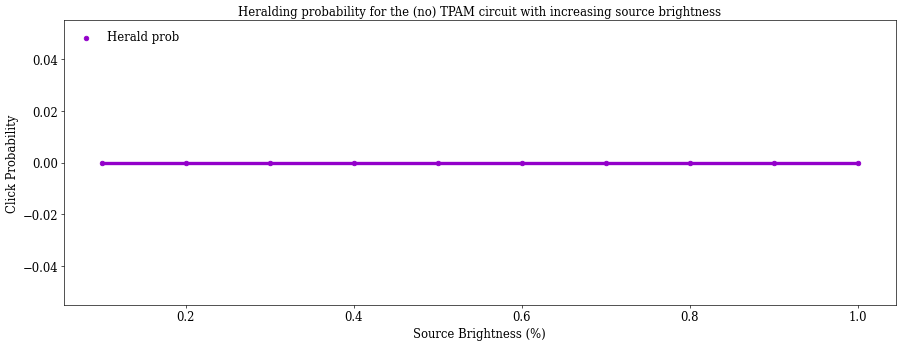

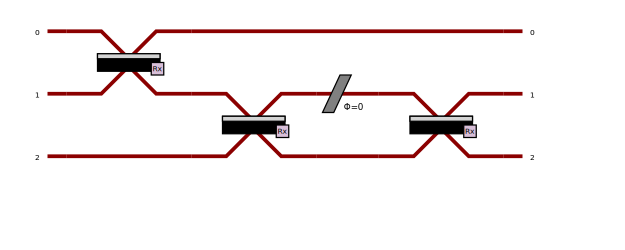

In [138]:

def define_no_TPAM_circuit():

    """Function which defines the TPAM circuit, but without
    the TPAM medium"""

    bs_50_50=pcvl.BS.Rx()
    no_TPAM_circuit=pcvl.Circuit(3, name="no TPAM LO")
    no_TPAM_circuit.add((0, 1), bs_50_50 )
    no_TPAM_circuit.add((1,2), bs_50_50 )
    no_TPAM_circuit.add( (1), pcvl.PS(phi=0))
    no_TPAM_circuit.add((1, 2), bs_50_50 )
    return no_TPAM_circuit


def run_simulation(source_bs=[0.8, 0.8, 0.0],
                   source_ps=[1,1,1],
                   print_state_evolution=False):

    """This function actually runs the simulation. Generates and evolves the state before measuring.
    Parameters:
                source_bs (arr) - array of floats between 0 and 1 representing the source brightnesses
                source_ps (arr) - array of floats between 0 and 1 representing the source purities
                print_state_evolution (bool) - Boolean for if you want to see the intermediate states

        Returns:
                click prob - The probablility of recieving a heralding click in this scheme, without the TPA.
    """

    #Generate input state from dot sources
    Input_state=prepare_input_state(n=3,
                                    source_brightnesses=source_bs,
                                    source_purities=source_ps)
    

    #Generate the linear optical circuit
    circuit=define_no_TPAM_circuit()
    
    #Evolve the mixed state through the circuit 
    post_circuit_state=evolve_mixed_state(circuit, Input_state)

    #Trace out the 0th mode 
    _, remaining_state, click_prob=measure_mixed_state(post_circuit_state,
                                                        meas_mode=0,
                                                        postselect_on_click=False)

    #Measure the first mode  
    _, post_measurement_state, click_prob=measure_mixed_state(remaining_state,
                                                            meas_mode=0,
                                                            postselect_on_click=True)
    
    if print_state_evolution:
        print('Input state is: {}'. format(Input_state))
        print('Post circuit state is: {}'. format(post_circuit_state))
        print('State after tracing out the irrelevant 0th mode is: {}'. format(remaining_state))
        print('Probability of getting a click when measuring the first mode is {}'.format(click_prob))


    return click_prob


def probs_vs_brightness(data_points=10):

    """This function runs the simulation for a number of different brightnesses of the sources,
    and plots the heralding probability for increasing source brightness, along with the boosted brightness.
    Parameters:
                data_points (int) - Number of brightness points to plot
    """
    
    brightnesses=np.linspace(0.1,1,data_points)
    herald_probs=[]
    photon_probs=[]

    for k in range(len(brightnesses)):

        hp=run_simulation(source_bs= [brightnesses[k],brightnesses[k], 0],
                        source_ps=[1,1,1],
                        print_state_evolution=False)
        
        herald_probs.append(hp*100)


    generic_line_plotter(x_values=[brightnesses],
                    y_values=[herald_probs],
                    color_indexes=[1],
                    x_label='Source Brightness (%)',
                    y_label='Click Probability' ,
                    data_labels=['Herald prob'],
                    title='Heralding probability for the (no) TPAM circuit with increasing source brightness')


probs_vs_brightness()

noTPAMCircuit=define_no_TPAM_circuit()
pcvl.pdisplay(noTPAMCircuit)

The above plot matches the claims of the paper. Irrelavant of the source brightness, you never get a click in the detector on mode 1. 


### Simulation with TPAM
Above we have simualted the case for a linear optical circuit with no TPAM mechanism and found the relevant probabilities. Now we add in this non-linear TPAM mechanism. Whilst perceval can natively handle some non-unitary componentry, it's not immediately clear to me how to implement a user specified non-unitary component. 

As such to simulate the TPAM circuit I split it up into a circuit before the TPAM component, which perceval can handle. Taking the output state from this I then act the TPAM mechanism on the input state. I then feed this state as input to a second perceval circuit representing the rest of the linear optics after the TPAM.

I have tried to define a function that allows for any non-linear map on a single mode number states. I have only benchmarked it for the TPAM case though so beware trusting it blindly.



In [139]:
#NOTE: Must split our circuit up into before TPA and after TPA and evolve separately.


def define_pre_TPAM_circuit():

    bs_50_50=pcvl.BS.Rx()
    pre_TPAM_circuit=pcvl.Circuit(3, name="pre TPAM LO")
    pre_TPAM_circuit.add((0, 1), bs_50_50 )
    pre_TPAM_circuit.add((1,2), bs_50_50 )

    return pre_TPAM_circuit

def define_post_TPAM_circuit():

    bs_50_50=pcvl.BS.Rx()
    post_TPAM_circuit=pcvl.Circuit(3, name="post TPAM LO")
    post_TPAM_circuit.add((1, 2), bs_50_50 )

    return post_TPAM_circuit


PreCircuit=define_pre_TPAM_circuit() 
PostCircuit=define_post_TPAM_circuit()


In [140]:
def run_TPAM_simulation(pre_circuit,
                        post_circuit,
                        source_bs=[1, 1, 0.0],
                        source_ps=[1,1,1],
                        beta=1,
                        print_state_evolution=False):

    """This function actually runs the simulation in the presence of TPA.
    Generates and evolves the state before measuring the probabilities we are interested in.

    Parameters:
                source_bs (arr) - array of floats between 0 and 1 representing the source brightnesses
                source_ps (arr) - array of floats between 0 and 1 representing the source purities
                beta (float)    - float between 0 and 1 representing the efficiency of the TPA process
                                  beta=0 is perfect TPA, beta=1 is no TPA.
                print_state_evolution (bool) - Boolean for if you want to see the intermediate states

        Returns:
                click prob - The probablility of recieving a heralding click
                meas_out - the probabilities associated with each number state in the output mode
    """


    #DEFINING INPUT STATE AND NONLINEARITY
    TPA_map={ '2': [[1-beta, '0'], [beta, '2']] } #Takes the 2 photons to 0 with probability 1-beta

    #Generate input state from dot sources and the TPAM circuit
    Input_state=prepare_input_state(n=3,
                                    source_brightnesses=source_bs,
                                    source_purities=source_ps)

    
    #PERFORM THE STATE EVOLUTION
    
    pre_tpam_state=evolve_mixed_state(pre_circuit, Input_state) #Evolve the mixed state through the pre-TPAM circuit

    post_tpam_state=evolve_mixed_state_through_non_linearity(                   #evolve state through TPAM
                                                input_mixed_state=pre_tpam_state, 
                                                mode=1,
                                                non_linear_map=TPA_map)

    post_circuit_state=evolve_mixed_state(post_circuit, post_tpam_state) #Evolve the mixed state through the post-TPAM circuit

    _ ,final_state , _=measure_mixed_state(post_circuit_state,    #Trace out the 0th mode as now unimportant
                                            meas_mode=0,
                                            postselect_on_click=False)


    
    #PERFORM MEASUREMENTS TO GET PROBABILITIES OF INTEREST:
    
    #Measure the 1st mode after the circuit 
    mode1_state, post_selected_state, click_prob =measure_mixed_state(final_state,
                                                                        meas_mode=0,
                                                                        postselect_on_state='|1>')

    #measure the 2nd mode output given a single photon click in mode 1 
    meas_out,_,_=measure_mixed_state(post_selected_state, 
                                                meas_mode=0)


    if print_state_evolution:
        print('State generated by sources is:{} \n'.format(Input_state))
        print('Input state to TPAM is: ', pre_tpam_state)
        print('Post TPAM state is: ', post_tpam_state)
        print('Final state is: ', post_circuit_state)
        print('Final state after tracing out mode 0 is', final_state)
        print('The remaining state, postselecting for |1> in mode B is: {}'.format(post_selected_state))
        print('Probabilities of having |1> in C given a single photon in B is: {}'.format(meas_out[pcvl.BasicState('|1>')]))
        print('Herlading probability is : {}'.format(click_prob))


    return click_prob, meas_out




In [141]:
def balanced_beamsplitter_theory_hp(brightness, beta):
    """Gives the theoretical heralding probaility for
    blanaced beamsplitter scheme, for a given brightness and beta"""

    return (1/16)*((np.abs(1-beta))**2)*brightness**2

def optimal_scheme_theory_hp(brightness, beta):
    """Gives the theoretical heralding probaility for
    optimal beamsplitter scheme, for a given brightness and beta"""
    return (27/256)*(brightness**2)*(1-beta)**2

C:\Users\SébastianCurrie\AppData\Local\Temp\ipykernel_9432\1905529825.py:100: UserWarning: You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.
  warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')


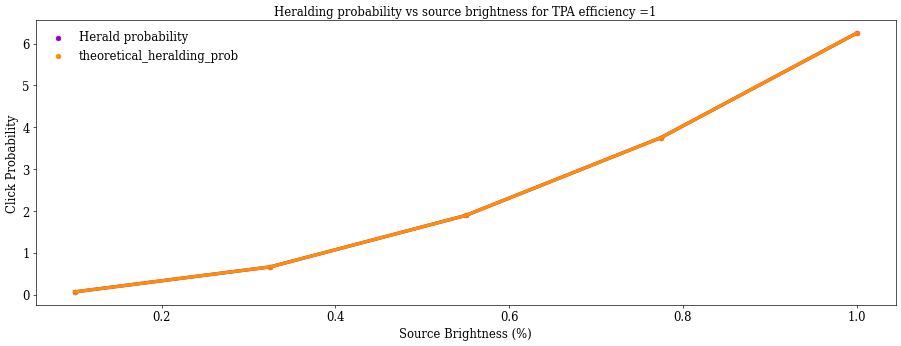

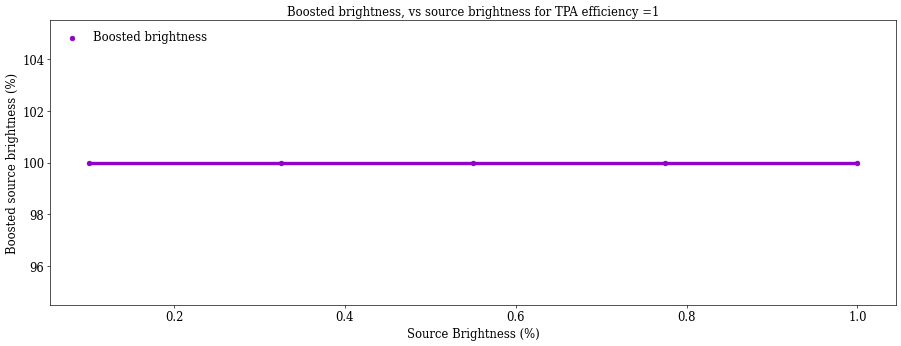

In [148]:
def TPAM_probs_vs_brightness(pre_circuit,
                            post_circuit,
                            brightnesses,
                            beta=0,
                            optimal_case=False,
                            print_state_evolution=False
):

    """This function runs the simulation for a number of different brightnesses of the sources,
    and plots the heralding probability for increasing source brightness, along with the boosted brightness.
    Parameters:
                pre_circuit (obj) - PCVL object representing the pre TPA linear optical circuit 
                pre_circuit (obj) - PCVL object representing the post TPA linear optical circuit 
                brightnesses (arr) - size 3 array of floats between 0 and 1 representing the source brightnesses
                beta (float)    - float between 0 and 1 representing the efficiency of the TPA process
                                  beta=0 is perfect TPA, beta=1 is no TPA
                print_state_evolution (bool) - Boolean for if you want to see the intermediate states
    """


    
    herald_probs=[]
    photon_probs=[]
    herald_probs_number_res=[]
    photon_probs_number_res=[]
    theoretical_heralding_prob=[]
    #Theoretical heralding probability from the paper for 50:50 BS's.


    for k in range(len(brightnesses)):
        
        if optimal_case:
            tp=optimal_scheme_theory_hp(brightnesses[k], beta=beta)
        else:
            tp=balanced_beamsplitter_theory_hp(brightnesses[k], beta=beta)

        hp,meas = run_TPAM_simulation(pre_circuit=pre_circuit,
                                    post_circuit=post_circuit,
                                    source_bs= [brightnesses[k],brightnesses[k], 0], 
                                    beta=beta,
                                    print_state_evolution=print_state_evolution)
        
        pp=meas[pcvl.BasicState('|1>')]
        
        theoretical_heralding_prob.append(tp*100)
        herald_probs.append(hp*100)
        photon_probs.append(pp*100)


    generic_line_plotter(x_values=[brightnesses, brightnesses],
                    y_values=[herald_probs, theoretical_heralding_prob],
                    color_indexes=[1,3],
                    x_label='Source Brightness (%)',
                    y_label='Click Probability' ,
                    data_labels=['Herald probability', 'theoretical_heralding_prob'],
                    title='Heralding probability vs source brightness for TPA efficiency ={}'.format(1-beta))

    generic_line_plotter(x_values=[brightnesses],
                y_values=[photon_probs],
                color_indexes=[1],
                x_label='Source Brightness (%)',
                y_label='Boosted source brightness (%)' ,
                data_labels=['Boosted brightness'],
                title='Boosted brightness, vs source brightness for TPA efficiency ={}'.format(1-beta))


def plot_50_50_circuit():
    pre_circuit=define_pre_TPAM_circuit()
    post_circuit=define_post_TPAM_circuit()
    brightnesses=np.linspace(0.1,1,5)
    TPAM_probs_vs_brightness(pre_circuit=pre_circuit,
                            post_circuit=post_circuit,
                            brightnesses=brightnesses,
                            beta=0)
plot_50_50_circuit()



The above graphs reproduce the papers results for the 50:50 beamsplitters case. We always have a photon when we get a click (100% boosted brightness), but the probability of this occuring reaches maximally ~6%.


Now try to alter the linear optical circuits to optmise the herlading probaility as they do in the paper:

C:\Users\SébastianCurrie\AppData\Local\Temp\ipykernel_9432\1905529825.py:100: UserWarning: You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.
  warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')


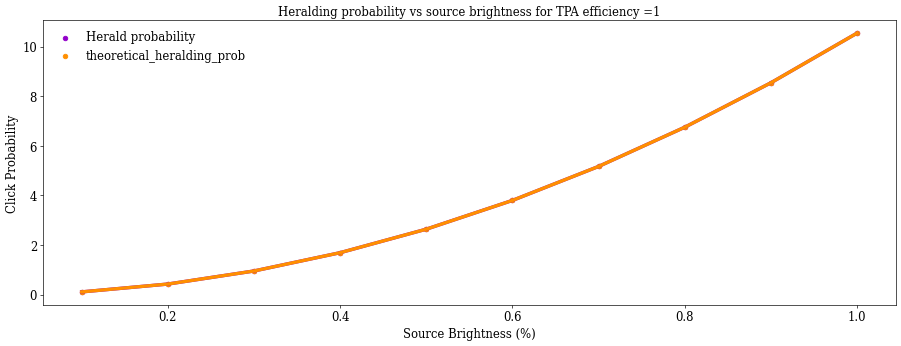

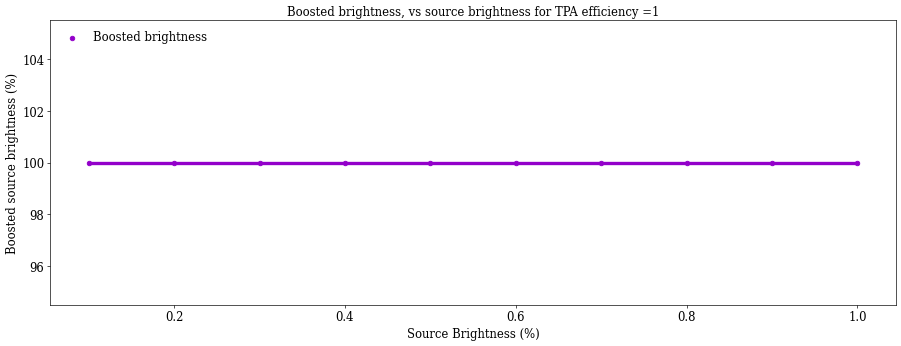

In [149]:
def r_to_theta(r):
    return 2*np.arccos(np.sqrt(float(r)))



def optimal_pre_TPAM_circuit():

    bs_50_50=pcvl.BS.Rx()
    bs_opt=pcvl.BS(theta=r_to_theta(3/4), phi_bl=0, phi_tr=0)
    pre_TPAM_circuit=pcvl.Circuit(3, name="pre TPAM LO")
    pre_TPAM_circuit.add((0, 1), bs_50_50 )
    pre_TPAM_circuit.add((1,2), bs_opt)

    return pre_TPAM_circuit

def optimal_post_TPAM_circuit():
    bs_opt=pcvl.BS(theta=r_to_theta(1/4),  phi_bl=0, phi_tr=0)
    post_TPAM_circuit=pcvl.Circuit(3, name="post TPAM LO")
    post_TPAM_circuit.add((1, 2), bs_opt )

    return post_TPAM_circuit

def plot_optimal_circuit():
    optimal_pre_circuit=optimal_pre_TPAM_circuit()
    optimal_post_circuit=optimal_post_TPAM_circuit()
    brightnesses_optimal=np.linspace(0.1,1,10)

    TPAM_probs_vs_brightness(pre_circuit=optimal_pre_circuit,
                            post_circuit=optimal_post_circuit,
                            brightnesses=brightnesses_optimal,
                            beta=0,
                            optimal_case=True,
                            print_state_evolution=False)

                            
plot_optimal_circuit()

Again we have reproduced the results of the optimal scheme given in the paper. The heraliding probability observed matches the theoretical value perfectly.

Now we can get onto the more interesting cases of seeing how the scheme is affected by imperfections.

### Imperfect TPA

So far we have looked at the probabilities when the TPA is 100% efficient. That is, two photons are always absorbed upon passing through.
The brightness boosting is independent of the TPA strength,and we have a simple analytical expression that shows how the heralding probability changes with the TPA efficiency:

For the optimal scheme, if the source brightness is p and the TPA efficiency is $(1-\beta)$:

$P_{succ}=\frac{27}{256} p^2 (1-\beta)^2$

We plot this as  a countour:

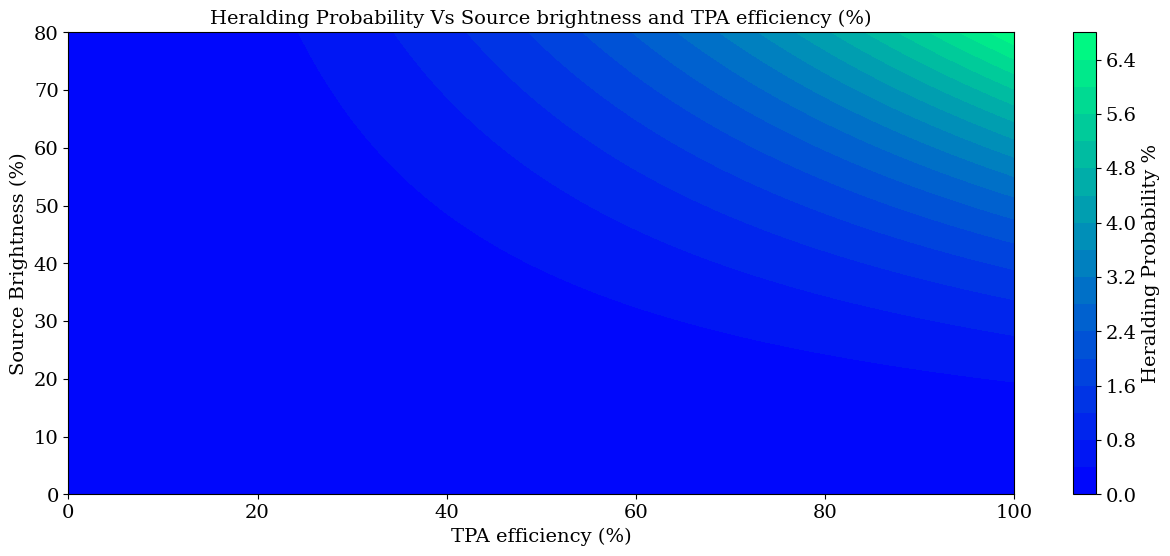

In [144]:
def beta_p_contour():

    no_points=1000
    hps=[]
    TPA_eff=np.linspace(0,1, no_points)

    ps=np.linspace(0,0.8, no_points)
    fig, ax=plt.subplots(1,1)
    colour_choice=plt.get_cmap('winter')
    
    X,Y=np.meshgrid(TPA_eff, ps)

    for i in  range(len(TPA_eff)):
        hps.append(optimal_scheme_theory_hp(beta=(1-X[i]), brightness=Y[i]))

    for t in range(len(TPA_eff)):
        X[t]=X[t]*100
        Y[t]=Y[t]*100
        hps[t]=hps[t]*100
    

    cp=ax.contourf(X,Y,hps, cmap=colour_choice, levels=20)
    
    ax.set_ylabel('Source Brightness (%)')
    ax.set_xlabel('TPA efficiency (%)')
    ax.set_title ('Heralding Probability Vs Source brightness and TPA efficiency (%)')

    fig.colorbar(cp, label='Heralding Probability %')

    plt.show()


beta_p_contour()

This plot makes it clear that to use this scheme we would have to take a _large_ rates hit, realistically between 2 to 3 orders of magnitude in rate.


### The effect of Purity

Now we want to look at the effect of impurity on this scheme. NOTE: After some discussion with Stephen I became aware thate there is currently a bug in percevals native handling of purity and brightness, and so we do some manual solving to get the correct purity value.

In perceval the brightness is defined as $B=p_1+p_2$, where $p_1$ is the probability of having 1 photon, and $p_2$ is the probability of having 2.

Purity is defined as $P = 1 - \frac{p_2}{p_1 + p_2}  = 1 - \frac{p_2}{B}  $. So if you alter the brightness, you also alter the purity of the state. 


What we want to study here, really, is the effect of $g^{(2)}$ on this scheme, so we rewrite the purity in terms of $g^{(2)}$ and $B$, and then solve for purity:

\begin{equation}
P = \frac{2 B g^{(2)} + \sqrt{1-2Bg^{(2)}} -1}{Bg^{(2)}}
\end{equation}




0.0% complete


C:\Users\SébastianCurrie\AppData\Local\Temp\ipykernel_9432\1905529825.py:100: UserWarning: You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.
  warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')


20.0% complete
40.0% complete
60.0% complete
80.0% complete


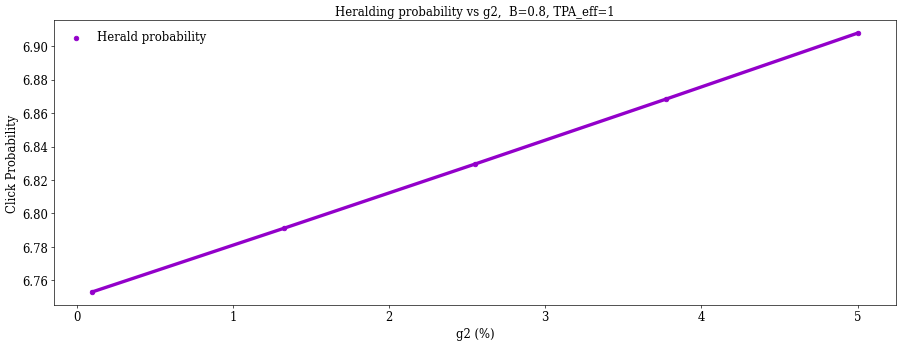

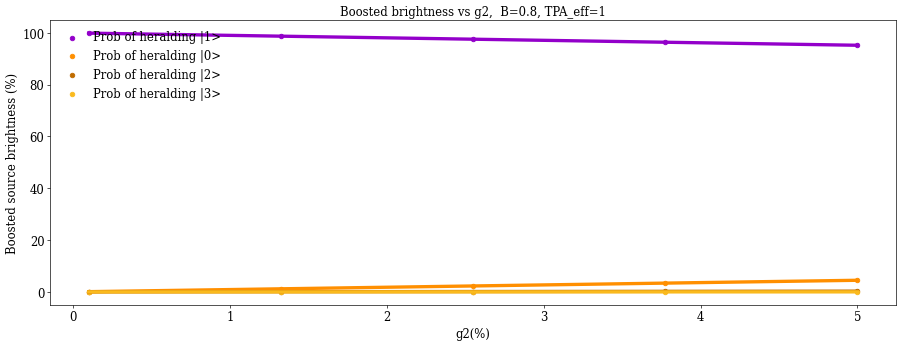

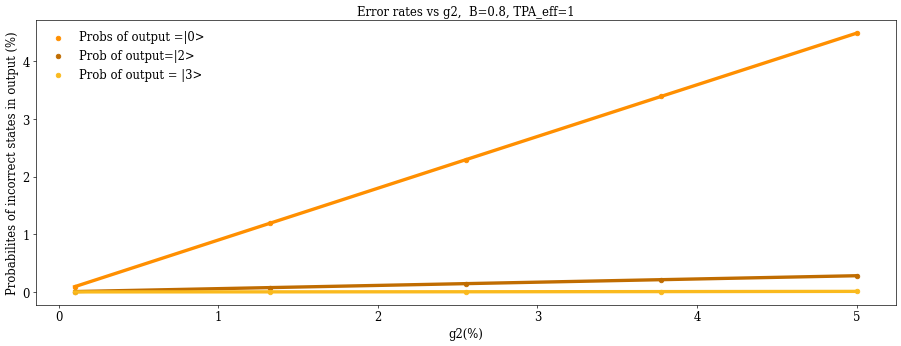

In [147]:
if str(pcvl.__version__)!='0.7.2':
    warnings.warn("""The definition of purity here was specifically used to work around a bug in this version of perceval.
             If your version does not match this, an update may have fixed this bug, and this code will not work correctly""")

def purity_value(B,g2):
    return (2*B*g2 + np.sqrt(1-2*B*g2)-1)/(B*g2)


def TPAM_probs_vs_purity(pre_circuit,
                            post_circuit,
                            g2s,
                            brightnesses=[0.8,0.8,0],
                            beta=0,
                            print_state_evolution=False):

    """This function runs the simulation for a number of different purities of the sources,
    and plots the heralding probability along with the boosted brightness.
    Parameters:
                pre_circuit (obj) - PCVL object representing the pre TPA linear optical circuit 
                pre_circuit (obj) - PCVL object representing the post TPA linear optical circuit 
                brightnesses (arr) - size 3 array of floats between 0 and 1 representing the source brightnesses
                beta (float)    - float between 0 and 1 representing the efficiency of the TPA process
                                  beta=0 is perfect TPA, beta=1 is no TPA
                print_state_evolution (bool) - Boolean for if you want to see the intermediate states
    """

    purities=[]
    two_photon_probs=[]
    three_photon_probs=[]
    vacuum_probs=[]
    herald_probs=[]
    photon_probs=[]

    for g in range(len(g2s)):
        purities.append(purity_value(brightnesses[0],g2s[g]))
        g2s[g]=g2s[g]*100


    for k in range(len(purities)):
        print('{}% complete'.format( np.around( (100*(k) /len(purities)), 4 )))
        hp,meas = run_TPAM_simulation(pre_circuit=pre_circuit,
                                    post_circuit=post_circuit,
                                    source_bs= [brightnesses[0],brightnesses[1], 0], 
                                    source_ps=[purities[k], purities[k],1],
                                    beta=beta,
                                    print_state_evolution=print_state_evolution)

        pp=meas[pcvl.BasicState('|1>')]
        vp=meas[pcvl.BasicState('|0>')]
        tp=meas[pcvl.BasicState('|2>')]
        threep=meas[pcvl.BasicState('|3>')]
        
        

        herald_probs.append(hp*100)
        photon_probs.append(pp*100)
        vacuum_probs.append(vp*100)
        two_photon_probs.append(tp*100)
        three_photon_probs.append(threep*100)
        


    generic_line_plotter(x_values=[g2s],
                    y_values=[herald_probs],
                    color_indexes=[1,3],
                    x_label='g2 (%)',
                    y_label='Click Probability' ,
                    data_labels=['Herald probability'],
                    title='Heralding probability vs g2,  B={}, TPA_eff={}'.format(brightnesses[0], (1-beta)))

    generic_line_plotter(x_values=[g2s, g2s, g2s, g2s],
                y_values=[photon_probs, vacuum_probs, two_photon_probs, three_photon_probs],
                color_indexes=[1,3,4,5],
                x_label='g2(%)',
                y_label='Boosted source brightness (%)' ,
                data_labels=['Prob of heralding |1>', 'Prob of heralding |0>', 'Prob of heralding |2>', 'Prob of heralding |3>'],
                title='Boosted brightness vs g2,  B={}, TPA_eff={}'.format(brightnesses[0], (1-beta)))

    generic_line_plotter(x_values=[g2s, g2s,g2s],
            y_values=[vacuum_probs,two_photon_probs, three_photon_probs],
            color_indexes=[3,4,5],
            x_label='g2(%)',
            y_label='Probabilites of incorrect states in output (%)' ,
            data_labels=['Probs of output =|0>', 'Prob of output=|2>', 'Prob of output = |3>'],
            title='Error rates vs g2,  B={}, TPA_eff={}'.format(brightnesses[0], (1-beta)))



def purity_effects():
    """This function runs the simulation to study the effects of non-zero g2 on the scheme"""

    optimal_pre_circuit=optimal_pre_TPAM_circuit()
    optimal_post_circuit=optimal_post_TPAM_circuit()
    brightnesses=[0.8, 0.8, 0]
    g2s=np.linspace(0.001, 0.05, 5)
    

    TPAM_probs_vs_purity(pre_circuit=optimal_pre_circuit,
                        post_circuit=optimal_post_circuit,
                        brightnesses=brightnesses,
                        g2s=g2s,
                        beta=0,
                        print_state_evolution=False)


purity_effects()

### Combined effects if impurity and imperfect TPA

0.0% complete


C:\Users\SébastianCurrie\AppData\Local\Temp\ipykernel_9432\226211133.py:67: UserWarning: You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.
  warnings.warn('You have asked to postselect on an event with 0 probability. This may well break my code, proceed with caution.')


20.0% complete
40.0% complete
60.0% complete
80.0% complete


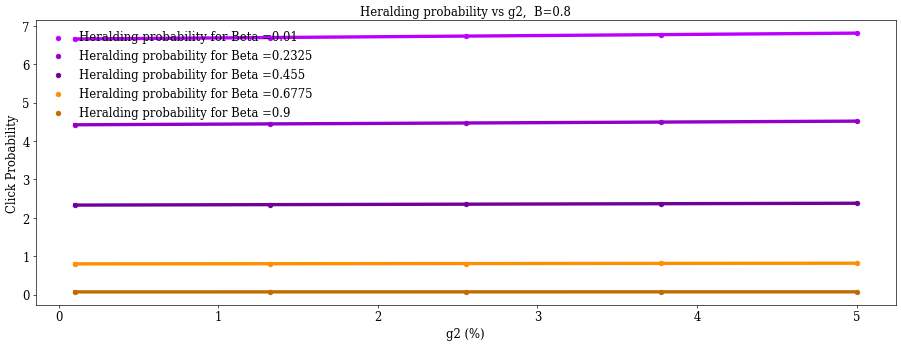

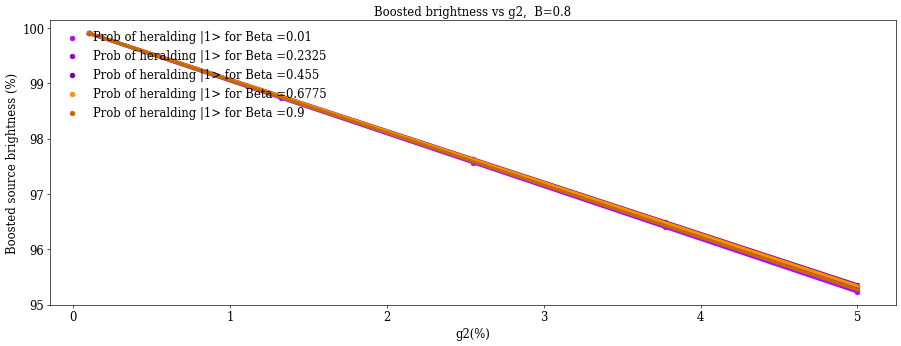

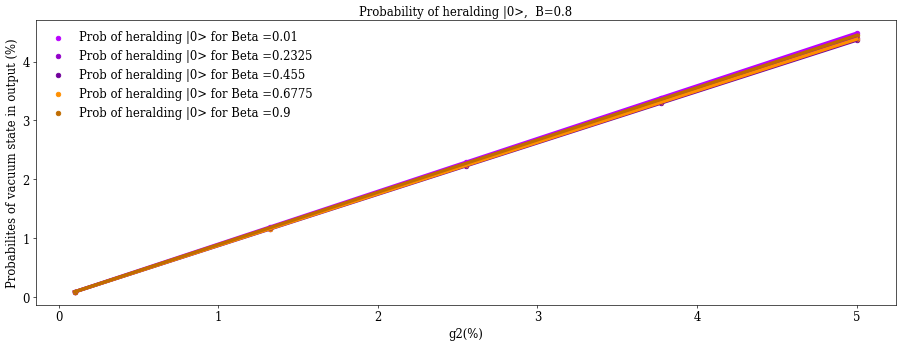

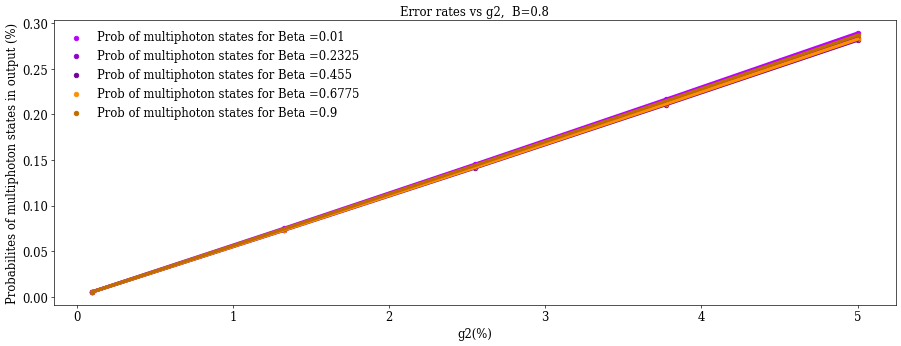

In [134]:

if str(pcvl.__version__)!='0.7.2':
    warnings.warn("""The definition of purity here was specifically used to work around a bug in this version of perceval.
             If your version does not match this, an update may have fixed this bug, and this code will not work correctly""")

def purity_value(B,g2):
    """Takes a brightness and a g2 and turns it into a purity value to be fed into perceval"""
    return (2*B*g2 + np.sqrt(1-2*B*g2)-1)/(B*g2)


def beta_purity_sims(pre_circuit,
                    post_circuit,
                    brightnesses,
                    g2s,
                    betas,
                    print_state_evolution=False):

    """This function runs the simulation for a number of different purities of the sources,
    and plots the heralding probability along with the boosted brightness.
    Parameters:
                pre_circuit (obj) - PCVL object representing the pre TPA linear optical circuit 
                pre_circuit (obj) - PCVL object representing the post TPA linear optical circuit 
                brightnesses (arr) - size 3 array of floats between 0 and 1 representing the source brightnesses
                g2s (arr)          - Float array between 0 and 1, representing the input state g2
                betas (arr)    - float array between 0 and 1 representing the efficiencies of the TPA process
                                  beta=0 is perfect TPA, beta=1 is no TPA
                print_state_evolution (bool) - Boolean for if you want to see the intermediate states
    """

    #Generate an empty set of lists to hold our data
    purities= []
    multi_photon_probs=[[] for x in range(len(betas))]
    vacuum_probs=[[] for x in range(len(betas))]
    herald_probs=[[] for x in range(len(betas))]
    single_photon_probs=[[] for x in range(len(betas))]
    

    #Turn our g2 values into purities
    for g in range(len(g2s)):
        purities.append(purity_value(brightnesses[0],g2s[g]))
        g2s[g]=g2s[g]*100

    #for a range of different betas, loop through purities and calculate values
    for b in range(len(betas)):

        print('{}% complete'.format( np.around( (100*(b) /len(betas)), 4 )))

        for k in range(len(purities)):

            hp,meas = run_TPAM_simulation(pre_circuit=pre_circuit,
                                        post_circuit=post_circuit,
                                        source_bs= [brightnesses[0],brightnesses[1], 0], 
                                        source_ps=[purities[k], purities[k],1],
                                        beta=betas[b],
                                        print_state_evolution=print_state_evolution)

            #Read of the appropriate probabilities
            mmp=0
            for state, prob in meas.items():
                if str(state)=='|1>':
                    single_photon_probs[b].append(prob*100)
                elif str(state)=='|0>':
                    vacuum_probs[b].append(prob*100)
                else:
                    mmp+=prob*100
            multi_photon_probs[b].append(mmp)
            herald_probs[b].append(hp*100)
        

    herlading_plot_labels=['Heralding probability for Beta ={}'.format(betas[j]) for j in range(len(betas)) ]
    generic_line_plotter(x_values=[g2s for k in range(len(betas))],
                        y_values=herald_probs,
                        color_indexes=[i for i in range(len(betas))],
                        x_label='g2 (%)',
                        y_label='Click Probability' ,
                        data_labels=herlading_plot_labels,
                        title='Heralding probability vs g2,  B={}'.format(brightnesses[0]))

    single_photon_labels=['Prob of heralding |1> for Beta ={}'.format(betas[j]) for j in range(len(betas)) ]
    generic_line_plotter(x_values=[g2s for k in range(len(betas))],
                        y_values=single_photon_probs,
                        color_indexes=[i for i in range(len(betas))],
                        x_label='g2(%)',
                        y_label='Boosted source brightness (%)' ,
                        data_labels=single_photon_labels,
                        title='Boosted brightness vs g2,  B={}'.format(brightnesses[0]))

    vacuum_labels=['Prob of heralding |0> for Beta ={}'.format(betas[j]) for j in range(len(betas)) ]
    generic_line_plotter(x_values=[g2s for k in range(len(betas))],
                        y_values=vacuum_probs,
                        color_indexes=[i for i in range(len(betas))],
                        x_label='g2(%)',
                        y_label='Probabilites of vacuum state in output (%)' ,
                        data_labels=vacuum_labels,
                        title='Probability of heralding |0>,  B={}'.format(brightnesses[0]))

    multi_photon_labels=['Prob of multiphoton states for Beta ={}'.format(betas[j]) for j in range(len(betas)) ]
    generic_line_plotter(x_values=[g2s for k in range(len(betas))],
                        y_values=multi_photon_probs,
                        color_indexes=[i for i in range(len(betas))],
                        x_label='g2(%)',
                        y_label='Probabilites of multiphoton states in output (%)' ,
                        data_labels=multi_photon_labels,
                        title='Error rates vs g2,  B={}'.format(brightnesses[0]))
            


def run_beta_purity_effects():
    """This function runs the simulation to study the effects of non-zero g2 on the scheme"""

    optimal_pre_circuit=optimal_pre_TPAM_circuit()
    optimal_post_circuit=optimal_post_TPAM_circuit()
    brightnesses=[0.8, 0.8, 0]
    g2s=np.linspace(0.001, 0.05, 5)
    betas=np.linspace(0.01,0.9,5)

    beta_purity_sims(pre_circuit=optimal_pre_circuit,
                        post_circuit=optimal_post_circuit,
                        brightnesses=brightnesses,
                        g2s=g2s,
                        betas=betas,
                        print_state_evolution=False)


run_beta_purity_effects()

To adds:

1) Bad detectors case 
2) Linear loss case 
3) Distinguishability case 
4) An optimiser which can perform a LO circuit before and after a TPA non-linearity, along with measurement on a given mode. See if there are any other schemes via brute force numerical analysis.

[array([0.001, 0.05 ]), array([0.001, 0.05 ]), array([0.001, 0.05 ]), array([0.001, 0.05 ]), array([0.001, 0.05 ])]
